# simran4@wisc.edu
# rgundavarapu@wisc.edu

In [1]:
from cassandra.cluster import Cluster
try:
    cluster = Cluster(['project-5-srh4dawin-db-1', 'project-5-srh4dawin-db-2', 'project-5-srh4dawin-db-3'])
    cass = cluster.connect()
    cass.execute("drop keyspace if exists weather")
except Exception as e:
    print(e)

# Part 1: Station Metadata

In [2]:
# DATA SETUP

cass.execute("""
CREATE KEYSPACE weather 
WITH REPLICATION = {
    'class' : 'SimpleStrategy', 
    'replication_factor' : 3 
    };
""")

cass.execute("""
CREATE TYPE 
    weather.station_record (tmin int, tmax int)
""")

cass.execute("""
CREATE TABLE weather.stations (
    id text,
    name text STATIC,
    date date,
    record weather.station_record,
    state text,
    PRIMARY KEY (id,date)
) WITH CLUSTERING ORDER BY (date asc)
""")

In [3]:
import pandas as pd
pd.DataFrame(cass.execute("describe keyspaces"))

,keyspace_name,type,name
0,system,keyspace,system
1,system_auth,keyspace,system_auth
2,system_distributed,keyspace,system_distributed
3,system_schema,keyspace,system_schema
4,system_traces,keyspace,system_traces
5,system_views,keyspace,system_views
6,system_virtual_schema,keyspace,system_virtual_schema
7,weather,keyspace,weather


# Q1

In [4]:
print(cass.execute("describe keyspace weather").one().create_statement)
print(cass.execute("describe table weather.stations").one().create_statement)

CREATE KEYSPACE weather WITH replication = {'class': 'SimpleStrategy', 'replication_factor': '3'}  AND durable_writes = true;
CREATE TABLE weather.stations (
    id text,
    date date,
    name text static,
    state text,
    record station_record,
    PRIMARY KEY (id, date)
) WITH CLUSTERING ORDER BY (date ASC)
    AND additional_write_policy = '99p'
    AND bloom_filter_fp_chance = 0.01
    AND caching = {'keys': 'ALL', 'rows_per_partition': 'NONE'}
    AND cdc = false
    AND comment = ''
    AND compaction = {'class': 'org.apache.cassandra.db.compaction.SizeTieredCompactionStrategy', 'max_threshold': '32', 'min_threshold': '4'}
    AND compression = {'chunk_length_in_kb': '16', 'class': 'org.apache.cassandra.io.compress.LZ4Compressor'}
    AND crc_check_chance = 1.0
    AND default_time_to_live = 0
    AND extensions = {}
    AND gc_grace_seconds = 864000
    AND max_index_interval = 2048
    AND memtable_flush_period_in_ms = 0
    AND min_index_interval = 128
    AND read_repair

In [5]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("p5")
         .config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.2.0')
         .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
         .getOrCreate())

:: loading settings :: url = jar:file:/usr/local/lib/python3.10/dist-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d05aec69-35ea-4a05-aa3a-07777f683d22;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.2.0 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.2.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0.3 in central
	found com.github.stephenc.jcip#jcip-annotations;1.0-1 in central
	found com.gith

In [6]:
!curl 'https://pages.cs.wisc.edu/~harter/cs639/data/ghcnd-stations.txt' > ghcnd-stations.txt
df = spark.read.text("ghcnd-stations.txt")
df.write.saveAsTable('stations')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.1M  100 10.1M    0     0  19.3M      0 --:--:-- --:--:-- --:--:-- 19.3M


In [7]:
metadata=spark.sql("""
SELECT SUBSTRING(value,0,11) as id,SUBSTRING(value,42,30) as name
FROM stations
WHERE SUBSTRING(value,39,2) == 'WI'
""").collect()

In [8]:
def show_table():
    return pd.DataFrame(cass.execute("select * from weather.stations"))
show_table()

""


In [9]:
insert_weather_stations = cass.prepare("""
INSERT INTO weather.stations
(id,name)
VALUES
(?,?)
""")

In [10]:
for i in metadata:
    cass.execute(insert_weather_stations,(i[0],i[1]))
show_table()

,id,date,name,record,state
0,USC00479053,None,W BEND FIRE STN #2,None,None
1,USC00476398,None,PARK FALLS DNR HQ,None,None
2,USC00470268,None,APPOLONIA,None,None
3,USC00474110,None,JUNEAU,None,None
4,USC00475525,None,MINONG 5 WSW,None,None
...,...,...,...,...,...
1308,USC00479050,None,WEST BEND,None,None
1309,US1WIPC0004,None,RIVER FALLS 3.0 SE,None,None
1310,US1WIWK0016,None,MUSKEGO 1.0 W,None,None
1311,US1WIWK0086,None,WALES 0.4 NW,None,None


# Q2

In [11]:
for i in list(cass.execute("""
select id,token(id) from weather.stations  
""")):
    if i[0] == 'USC00470273':
        row_token = i[1]
row_token

-9014250178872933741

In [12]:
import subprocess
output= (subprocess.check_output(["nodetool","ring"])).decode().split('\n')
for i in output[5:53]:    ## loop over output and check for value that is greater than data token
    v_node=int(i[70:])
    if(v_node>=row_token):
        vnode_token = v_node
        break
vnode_token

-8215865411716809314

In [13]:
print(f'row token: ',row_token)
print(f'vnode token: ',vnode_token)

row token:  -9014250178872933741
vnode token:  -8215865411716809314


# Part 2:Temperature Data

In [14]:
!curl https://pages.cs.wisc.edu/~harter/cs639/data/wi-stations.zip > wi-stations.zip
import zipfile as zf
zf.ZipFile('wi-stations.zip').extractall()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  126M  100  126M    0     0  68.7M      0  0:00:01  0:00:01 --:--:-- 68.7M


In [15]:
import station_pb2_grpc, station_pb2, grpc
import pandas as pd
from datetime import datetime
channel = grpc.insecure_channel('6840864d03c8:5440')
stub = station_pb2_grpc.StationStub(channel)
def simulate_sensor(station):
    # TODO: loop over tmin/tmax data for every day of 2022 for the given station;
    # send each to server with RecordTemps call
    df = spark.read.format("csv").option("compression", "gzip").load(f'{station}.csv.gz')
    df.write.saveAsTable(f'{station}', mode='overwrite')
    hello=spark.sql(f""" 
    select *,SUBSTRING(_c1,0,4) as year,concat(SUBSTRING(_c1,0,4),'-',SUBSTRING(_c1,5,2),'-',SUBSTRING(_c1,7,2)) as date 
    from {station}
    where SUBSTRING(_c1,0,4) == 2022 and (_c2 =='TMIN' or _c2=='TMAX')
    """).toPandas()
    hello=hello.pivot(columns='_c2',values='_c3',index='date')
    for i in hello.iterrows():
        fail=stub.RecordTemps(station_pb2.RecordTempsRequest(station=station,date=i[0],tmin=int(i[1].TMIN),tmax=int(i[1].TMAX)))

for station in ["USW00014837", "USR0000WDDG", "USW00014898", "USW00014839"]:
    simulate_sensor(station)
    r = stub.StationMax(station_pb2.StationMaxRequest(station=station))
    if r.error:
        print(r.error)
    else:
        print(f"max temp for {station} is {r.tmax}")

max temp for USW00014837 is 356
max temp for USR0000WDDG is 344


max temp for USW00014898 is 356


max temp for USW00014839 is 378


## PART 3

## Q3

In [16]:
spark.conf.set("spark.sql.catalog.cassandra", "com.datastax.spark.connector.datasource.CassandraCatalog")
spark.conf.set("spark.sql.catalog.cassandra.spark.cassandra.connection.host", "project-5-srh4dawin-db-3:9042")

spark.table("cassandra.weather.stations")

DataFrame[id: string, date: date, record: struct<tmin:int,tmax:int>, state: string, name: string]

In [17]:
spark.table("cassandra.weather.stations").createOrReplaceTempView("weather2022")
spark.table("weather2022").cache()

DataFrame[id: string, date: date, record: struct<tmin:int,tmax:int>, state: string, name: string]

In [18]:
def to_fahrenheit(temp):
    temp=temp/10
    return((temp)*1.8 + 32)
to_fahrenheit(200)

68.0

In [19]:
lows_highs=spark.sql("""
SELECT record,date
FROM weather2022
where id = 'USW00014837'
""").toPandas()

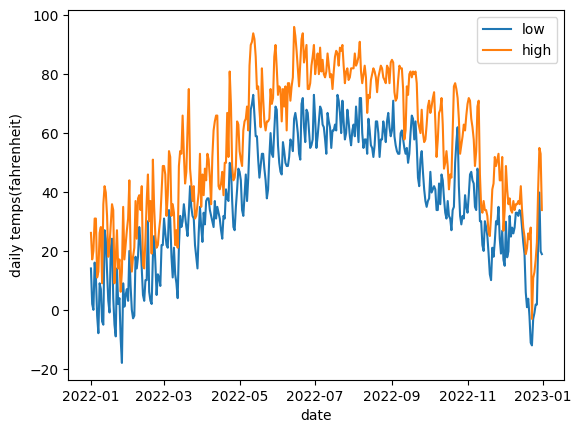

In [20]:
high_temps=[]
low_temps=[]
dates=[i for i in lows_highs['date']]
import matplotlib.pyplot as plt
for i in lows_highs['record']:
    high_temps.append(to_fahrenheit(max(i)))
    low_temps.append(to_fahrenheit(min(i)))
plt.plot(dates,low_temps)
plt.plot(dates,high_temps)
plt.xlabel('date')
plt.ylabel('daily temps(fahrenheit)')
plt.legend(["low", "high"])

## Q4

In [21]:
madison = spark.sql("""
SELECT record
FROM weather2022
where id = 'USW00014837'
""").toPandas()
milwaukee=spark.sql("""
SELECT record
FROM weather2022
where id = 'USW00014839'
""").toPandas()

In [22]:
madison_max_temps=[]
from pyspark.sql.functions import corr
milwaukee_max_temps=[]
for i in madison['record']:
    madison_max_temps.append(max(i))
for i in milwaukee['record']:
    milwaukee_max_temps.append(max(i))
df = spark.createDataFrame(zip(madison_max_temps, milwaukee_max_temps), ["madison", "milwaukee"])
df.agg(corr("madison", "milwaukee").alias('correlation')).collect()

[Row(correlation=0.9786907979650685)]

## PART 4

## Q5

In [25]:
stub.StationMax(station_pb2.StationMaxRequest(station="USW00014837"))
## WE GET AN ERROR SINCE WE CLOSED THE CONTAINER

error: "Error from server: code=1200 [Coordinator node timed out waiting for replica nodes\' responses] message=\"Operation timed out - received only 2 responses.\" info={\'consistency\': \'THREE\', \'required_responses\': 3, \'received_responses\': 2}"

23/04/17 04:08:45 WARN ChannelPool: [s0|/172.30.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=b1f1f127-53dd-4c44-bcda-a3b1e1631db9, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681704382340}): failed to send request (java.nio.channels.NotYetConnectedException))
23/04/17 04:08:54 WARN ChannelPool: [s0|/172.30.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=b1f1f127-53dd-4c44-bcda-a3b1e1631db9, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681704382340}): failed to send request (java.nio.channels.NotYetConnectedException))
23/04/17 04:09:07 WARN ChannelPool: [s0|/172.30.0.3:9042]  Err

## Q6

In [26]:
simulate_sensor("USC00477115")
## NOT WORKING

23/04/17 04:10:50 WARN ChannelPool: [s0|/172.30.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=b1f1f127-53dd-4c44-bcda-a3b1e1631db9, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681704382340}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))


## Q7

In [27]:
before_count = spark.sql("SELECT COUNT(record) FROM weather2022").toPandas()
print("BEFORE REFRESH:",before_count['count(record)'][0])
spark.sql("REFRESH TABLE weather2022")
after_count = spark.sql("SELECT COUNT(record) FROM weather2022").toPandas()
print("AFTER REFRESH:",after_count['count(record)'][0])

BEFORE REFRESH: 1460
AFTER REFRESH: 1825


23/04/17 04:11:42 WARN ChannelPool: [s0|/172.30.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=b1f1f127-53dd-4c44-bcda-a3b1e1631db9, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681704382340}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelException))
23/04/17 04:12:39 WARN ChannelPool: [s0|/172.30.0.3:9042]  Error while opening new channel (ConnectionInitException: [s0|connecting...] Protocol initialization request, step 1 (STARTUP {CQL_VERSION=3.0.0, DRIVER_NAME=DataStax Java driver for Apache Cassandra(R), DRIVER_VERSION=4.13.0, CLIENT_ID=b1f1f127-53dd-4c44-bcda-a3b1e1631db9, APPLICATION_NAME=Spark-Cassandra-Connector-local-1681704382340}): failed to send request (com.datastax.oss.driver.shaded.netty.channel.StacklessClosedChannelExcept